# **TP2: Les réseaux sémantiques**


**Réalisé par : Meriem Fattah**

**Objectifs du TP :**

• Construire un réseau sémantique basé sur les relations entre concepts dans un texte.

• Analyser et visualiser le réseau pour découvrir des relations intéressantes et des concepts clés.

• Explorer les applications des réseaux sémantiques pour la recherche d'informations et l'analyse de texte.

# 1ère Partie : Préparation de l’environnement et création du réseau


**2. Importer les bibliothèques**


In [49]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

**3. Chargement du modèle de langage et du texte**


In [50]:
nlp = spacy.load("en_core_web_sm")


In [51]:
text = """
Artificial intelligence and machine learning are closely related fields.
Deep learning is a subset of machine learning that uses neural networks.
Natural language processing is a key application of artificial intelligence.
"""
doc = nlp(text)

**4. Extraire les entités et créer des relations basées sur leur co-occurrence dans la même
phrase.**






In [52]:
entities = []
relations = []

for sentence in doc.sents:
    # Extraire les chunks nominaux plutôt que juste les entités nommées
    ents_in_sentence = [chunk.text.lower() for chunk in sentence.noun_chunks
                       if any(keyword in chunk.text.lower()
                       for keyword in ['intelligence', 'learning', 'processing', 'networks'])]

    entities.extend(ents_in_sentence)

    # Créer des relations par co-occurrence
    for ent1, ent2 in combinations(ents_in_sentence, 2):
        relations.append((ent1, ent2))

# Supprimer les doublons
entities = list(set(entities))
relations = list(set(relations))


**5. Créer le graphe sémantique où les nœuds représentent des entités et les arêtes
représentent des relations de co-occurrence en utilisant NetworkX.**


In [53]:
# Créer un graphe non orienté
G = nx.Graph()
# Ajouter les entités en tant que nœuds
G.add_nodes_from(entities)
# Ajouter les relations en tant qu'arêtes
G.add_edges_from(relations)

**6. Visualisation du réseau**

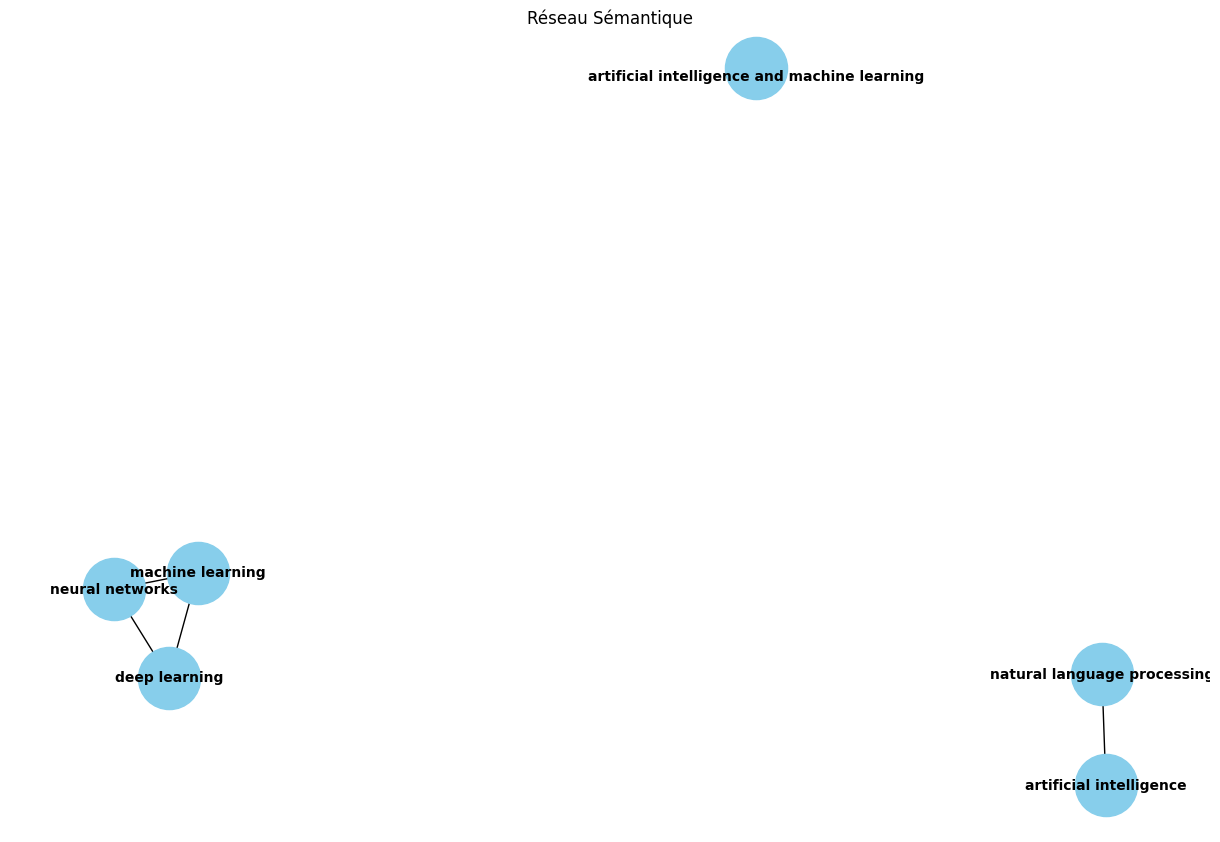


Entités détectées: ['natural language processing', 'neural networks', 'machine learning', '\nartificial intelligence and machine learning', 'artificial intelligence', 'deep learning']

Relations détectées: [('natural language processing', 'artificial intelligence'), ('deep learning', 'machine learning'), ('deep learning', 'neural networks'), ('machine learning', 'neural networks')]


In [54]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos,
       with_labels=True,
       node_color='skyblue',
       node_size=2000,
       font_size=10,
       font_weight='bold')
plt.title("Réseau Sémantique")
plt.show()

# Afficher les entités et relations détectées pour déboguer
print("\nEntités détectées:", entities)
print("\nRelations détectées:", relations)

D'après le réseau sémantique visualisé, nous pouvons observer une structure intéressante des concepts d'intelligence artificielle. Le graphe révèle deux clusters principaux : un premier cluster dans la partie gauche regroupant "machine learning", "deep learning" et "neural networks", montrant l'interconnexion forte entre ces technologies d'apprentissage ; et un second cluster à droite composé de "artificial intelligence" et "natural language processing", illustrant le lien entre l'IA et ses applications. Au centre du graphe, nous remarquons le concept "artificial intelligence and machine learning" qui agit comme un pont entre les deux clusters, en soulignant la relation fondamentale entre ces domaines. Les nœuds sont représentés en bleu clair avec une taille significative, ce qui facilite la lisibilité des relations. Les entités détectées (affichées en bas de l'image) confirment cette structure avec 6 concepts clés, et les relations détectées montrent les connexions directes entre ces concepts, notamment les liens entre "natural language processing" et "artificial intelligence", ainsi qu'entre "deep learning", "machine learning" et "neural networks". Cette visualisation met en évidence la hiérarchie et les interconnexions dans le domaine de l'IA.

#2ème Partie : Exploitation avancée du réseau



**1. Utiliser un corpus plus large**



In [55]:
larger_text = """
Artificial intelligence encompasses various technologies and approaches.
Machine learning algorithms can analyze large datasets efficiently.
Deep neural networks have revolutionized image recognition tasks.
Natural language processing enables computers to understand human language.
Computer vision systems can detect and classify objects in images.
Reinforcement learning helps agents make optimal decisions.
"""
doc_large = nlp(larger_text)

**2. Explorer les dépendances syntaxiques**


In [56]:
def get_syntactic_relations(doc):
    syntactic_relations = []
    for token in doc:
        if token.dep_ in ['nsubj', 'dobj', 'pobj']:
            relation = (token.text, token.head.text, token.dep_)
            syntactic_relations.append(relation)
    return syntactic_relations

syntactic_relations = get_syntactic_relations(doc_large)

**3. Mesure de similarité entre concepts**


In [57]:
def compute_similarity(doc, entities):
    similarity_edges = []
    tokens = [token for token in doc if not token.is_stop and not token.is_punct]
    for token1, token2 in combinations(tokens, 2):
        similarity = token1.similarity(token2)
        if similarity > 0.5:  # Seuil de similarité
            similarity_edges.append((token1.text, token2.text, similarity))
    return similarity_edges

similarity_edges = compute_similarity(doc_large, entities)

<ipython-input-57-8e758c811a41>:5: UserWarning:

[W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.



**Créer un nouveau graphe avec les relations de similarité**






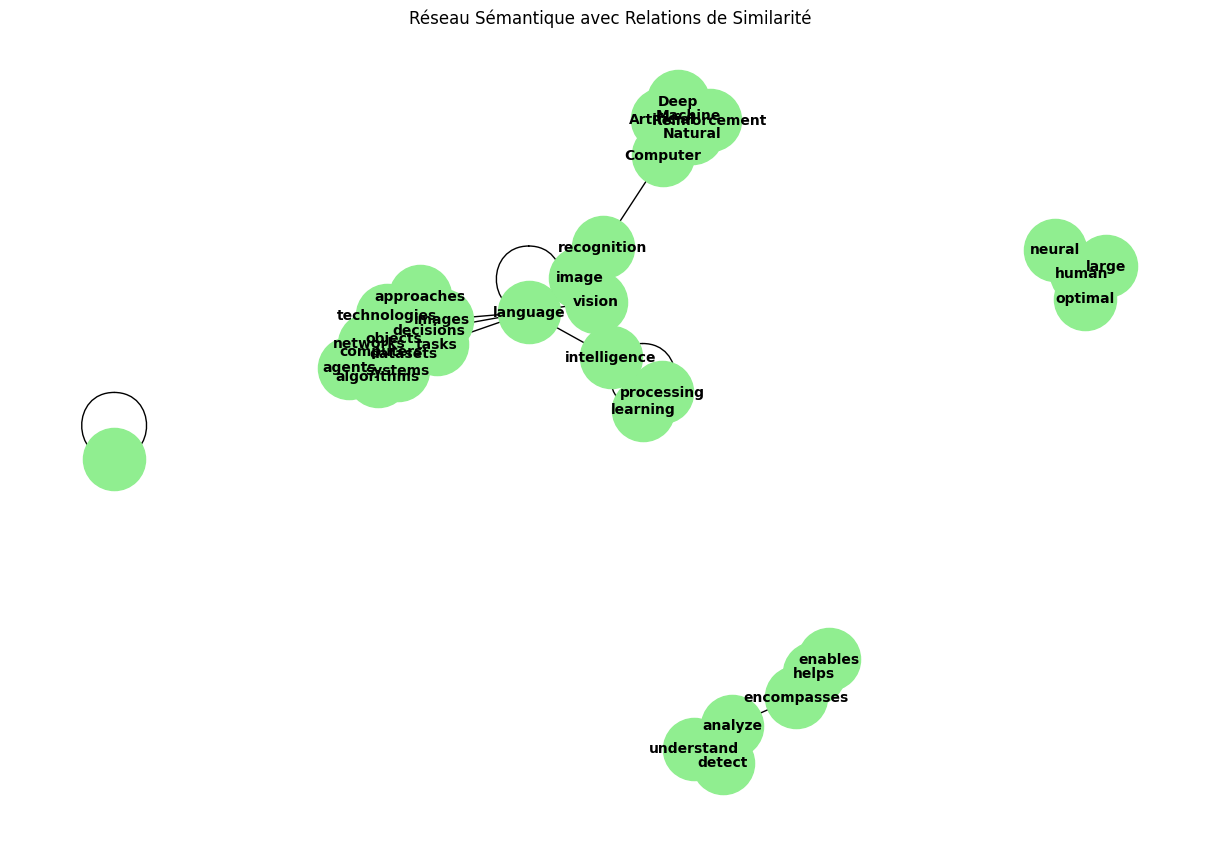

In [58]:

# Créer un nouveau graphe avec les relations de similarité
G_similarity = nx.Graph()
for edge in similarity_edges:
    G_similarity.add_edge(edge[0], edge[1], weight=edge[2])

# Visualiser le nouveau graphe
plt.figure(figsize=(12, 8))
pos_sim = nx.spring_layout(G_similarity)
nx.draw(G_similarity, pos_sim, with_labels=True,
        node_color='lightgreen',
        node_size=2000,
        font_size=10,
        font_weight='bold')
plt.title("Réseau Sémantique avec Relations de Similarité")
plt.show()


**4. Créer une interface graphique qui permet de naviguer à travers le réseau sémantique et
de visualiser les relations entre les concepts.**




In [59]:
import dash
from dash import html, dcc
import dash_cytoscape as cyto
import networkx as nx

# Créer le graphe de relations
G = nx.Graph()
G.add_nodes_from(entities)
G.add_edges_from(relations)

# Convertir le graphe en un format utilisable par Cytoscape
cy_edges = [{'data': {'source': source, 'target': target}} for source, target in G.edges()]
cy_nodes = [{'data': {'id': node, 'label': node}} for node in G.nodes()]

# Configurer l'application Dash
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Réseau Sémantique Interactif"),

    cyto.Cytoscape(
        id='cytoscape-graph',
        layout={'name': 'cose'},
        style={'width': '100%', 'height': '600px'},
        elements=cy_nodes + cy_edges,
        stylesheet=[
            {
                'selector': 'node',
                'style': {
                    'label': 'data(label)',
                    'background-color': '#87CEFA',
                    'width': '40px',
                    'height': '40px',
                    'font-size': '14px',
                    'color': '#333333'
                }
            },
            {
                'selector': 'edge',
                'style': {
                    'line-color': '#A9A9A9',
                    'width': 2
                }
            }
        ]
    )
])

# Exécuter l'application
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>